<h1 style="text-align: center;">Курсовой проект для курса "Python для Data Science"</h1>


**Задание:**

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).

С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

**Целевая переменная:**

Price

**Метрика качества:**

R2 - коэффициент детерминации (sklearn.metrics.r2_score) > 0.6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)
warnings.filterwarnings('ignore')

**Загрузим данные**

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


**Для удобства выводим информацию о данных**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


**Блок импорта пакетов и модулей**

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

**необходимо почистить и предобработать данные, построить несколько моделей и выбрать лучшую**

**Пока что заполним пропуски нулями**

Так как Id нам ничего не дает, но может повлиять на обучение, также удалять его нам нельзя, назначим это поле индексом

In [5]:
data = data.set_index('Id')
data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
cleared_data = data.fillna(0)

**Получим датафреймы X и у**


In [7]:
X = cleared_data.drop(labels=['Price'], axis=1)
X = pd.get_dummies(data=X, columns=['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2'], drop_first=True)
y = cleared_data['Price'].values

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

**Соберем данные r2_score по всем моделям**

Модели представим в виде списка, чтобы в цикле обработать данные и собрать результаты

Так как задача на регрессию, то и модели выбираются соответствующие

In [10]:
models_list = [LinearRegression, KNeighborsRegressor, DecisionTreeRegressor, RandomForestRegressor]

def get_r2_score(model):
    model_instance = model()
    model_instance.fit(X_train_scaled, y_train)
    y_pred_train = model_instance.predict(X_train_scaled)
    y_pred_valid = model_instance.predict(X_valid_scaled)
    score_train = r2_score(y_train, y_pred_train)
    score_valid = r2_score(y_valid, y_pred_valid)
    return score_train, score_valid
    
r2_scores = list(map(get_r2_score, models_list))

In [11]:
for model, scores in zip(models_list, r2_scores):
    print('{}:\n\ttrain: {}\n\tvalid: {}'.format(
        model.__name__,
        np.round(scores[0], 4),
        np.round(scores[1], 4)
    ))

LinearRegression:
	train: 0.6759
	valid: 0.5829
KNeighborsRegressor:
	train: 0.7495
	valid: 0.5906
DecisionTreeRegressor:
	train: 1.0
	valid: 0.523
RandomForestRegressor:
	train: 0.9495
	valid: 0.6958


**На данном этапе RandomForestRegressor показывет нам R2 Score == 0.6862 (если бы не избавился от ID было бы 0.6809)**

#### Посмотрим на распределение цены

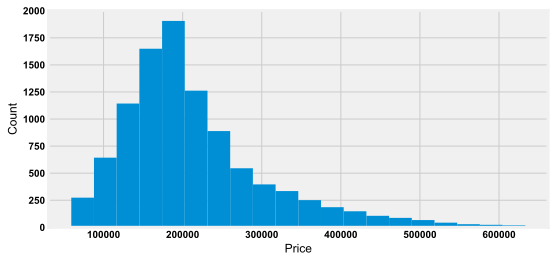

In [12]:
plt.figure(figsize=(8, 4))
data.Price.hist(bins=20)
plt.ylabel("Count")
plt.xlabel("Price")
plt.show()

#### Также посмотрим на распределение по комнатам

Думаю можно избавиться от квартир больше 6 комнат

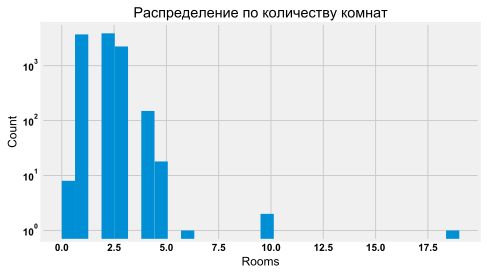

In [13]:
plt.figure(figsize=(7, 4))
data.Rooms.hist(bins=30, log=True)
plt.ylabel("Count")
plt.xlabel("Rooms")
plt.title("Распределение по количеству комнат")
plt.show()

In [14]:
data = data[data.Rooms <= 6]

Если посмотрим на распределение данных по площади, заметим выбросы, от которых тоже можно избавиться 

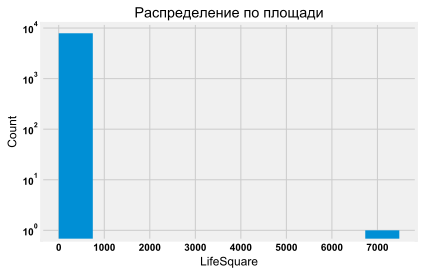

In [15]:
data.LifeSquare.hist(bins=10, log=True)
plt.ylabel("Count")
plt.xlabel("LifeSquare")
plt.title("Распределение по площади")
plt.show()

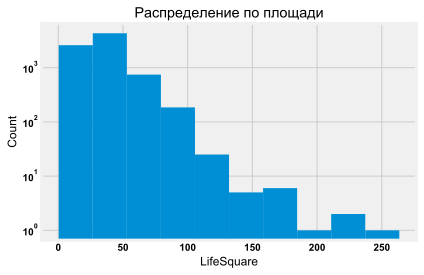

In [16]:
data = data[data.LifeSquare < 300]

data.LifeSquare.hist(bins=10, log=True)
plt.ylabel("Count")
plt.xlabel("LifeSquare")
plt.title("Распределение по площади")
plt.show()

Посмотрим на данные

In [17]:
data.describe()


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,7880.000000,7880.000000,7880.000000,7880.000000,7880.000000,7880.000000,7880.000000,7.880000e+03,7880.000000,7880.000000,7880.000000,7880.000000,4453.000000,7880.000000,7880.000000,7880.000000
mean,56.681091,1.915990,55.109192,36.079482,7.582614,8.151396,12.436802,4.530489e+03,0.122560,28.479949,6097.244416,7.260279,1211.554458,1.521066,4.528173,223430.110441
std,45.354756,0.824364,18.911859,18.017119,32.016932,5.084392,6.366504,2.258665e+05,0.120104,16.643271,3906.321070,19.633154,1068.431100,1.516776,4.425344,94935.732338
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,22.000000,1.000000,41.164647,22.768620,5.000000,4.000000,9.000000,1.971000e+03,0.025609,19.000000,3681.000000,1.000000,325.000000,0.000000,1.000000,162078.862732
50%,46.000000,2.000000,50.833144,32.766417,7.000000,7.000000,12.000000,1.979000e+03,0.081943,28.000000,5664.000000,2.000000,1015.000000,1.000000,4.000000,200016.674815
75%,88.000000,3.000000,64.686767,45.112286,9.000000,11.000000,17.000000,2.004000e+03,0.194489,38.000000,7759.000000,5.000000,1894.000000,3.000000,6.000000,262295.816302
max,209.000000,6.000000,275.645284,263.542020,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625678.644994


Мы видим значение 0 в min. Нужно привести к среднему

In [18]:
data_copy = data.fillna(0)

In [19]:
def preprocess_data(data_in):
    preprocessed_data = data_in.copy()
    
    idx = (preprocessed_data['HouseYear'] >= 2019)
    preprocessed_data.loc[idx, 'HouseYear'] = 2019
    
    square_median = dict(preprocessed_data.groupby('Rooms')['Square'].median())
    idx = (preprocessed_data['Rooms'] == 0)
    preprocessed_data.loc[idx, 'Rooms'] = preprocessed_data.loc[idx, 'Rooms'].\
        apply(lambda x: square_median[x])
    
    square_median = dict(preprocessed_data.groupby('Rooms')['Square'].median())
    idx = (preprocessed_data['Square'] < 15) & (preprocessed_data['Rooms'] < 2)
    preprocessed_data.loc[idx, 'Square'] = preprocessed_data.loc[idx, 'Rooms'].apply(lambda x: square_median[x])
    
    kitchen_square = dict(preprocessed_data.groupby('Rooms')['KitchenSquare'].median())
    idx = (preprocessed_data['Rooms'] > 0)
    preprocessed_data.loc[idx, 'KitchenSquare'] = preprocessed_data.loc[idx, 'Rooms'].apply(lambda x: kitchen_square[x])
    
    # 0 Этажей превращаем в 1
    idx = (preprocessed_data['HouseFloor'] == 0)
    preprocessed_data.loc[idx, 'HouseFloor'] = preprocessed_data.loc[idx, 'HouseFloor'].apply(lambda x: 1)
    
    # Приедем поля в Ecology_2, Ecology_3 и Shops_2 числовые

    preprocessed_data['Ecology_2'] = preprocessed_data['Ecology_2'].apply(lambda x: 1 if x == 'A' else 0)
    preprocessed_data['Ecology_3'] = preprocessed_data['Ecology_3'].apply(lambda x: 1 if x == 'A' else 0)
    preprocessed_data['Shops_2'] = preprocessed_data['Shops_2'].apply(lambda x: 1 if x == 'A' else 0)
    return preprocessed_data

In [20]:
data_copy = preprocess_data(data_copy)

X = data_copy.drop(labels=['DistrictId', 'Price'], axis=1)
y = data_copy['Price'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,
3500,2.0,54.796367,30.042933,6.0,3,14.0,1990,0.090799,0,0,74,19083,2,0.0,5,15,0
9097,2.0,64.822654,36.484535,6.0,3,1.0,1977,0.072158,0,0,2,629,1,0.0,0,0,1
7994,2.0,44.124658,30.455467,6.0,4,5.0,1966,0.174739,0,0,17,3379,9,100.0,0,3,0
2685,3.0,55.897360,35.909751,8.0,3,9.0,1979,0.037178,0,0,52,11217,1,2300.0,1,7,0
2087,1.0,40.505323,23.102152,7.0,14,17.0,2004,0.175055,0,0,36,10055,3,0.0,1,0,0


In [21]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


In [22]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
random_grid = {
    'n_estimators': np.arange(200, 501, 20),
    'max_depth': np.arange(2, 51, 2),
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [23]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=50,
    scoring='r2',
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [24]:
random_search.fit(X_train_scaled, y_train)
print(random_search.best_score_)
print(random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
0.699306314690273
{'n_estimators': 340, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 42}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.9min finished


In [25]:
y_pred_train = random_search.best_estimator_.predict(X_train_scaled)
y_pred_valid = random_search.best_estimator_.predict(X_valid_scaled)

score_train = r2_score(y_train, y_pred_train)
score_valid = r2_score(y_valid, y_pred_valid)

print('train: {}\nvalid: {}'.format(
    np.round(score_train, 4),
    np.round(score_valid, 4)
))

train: 0.9341
valid: 0.6889


обучим подобранную модель на всех тренировочных данных

In [26]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
rf_model = RandomForestRegressor(**random_search.best_params_)

rf_model.fit(X_scaled, y)

scores = cross_val_score(rf_model, X_scaled, y, scoring='r2', cv=10, n_jobs=-1)

print('cv mean: {}'.format(np.round(np.mean(scores), 4)))
print('cv std:  {}'.format(np.round(np.std(scores), 4)))

cv mean: 0.7074
cv std:  0.023


In [32]:
test_data = pd.read_csv('test.csv', index_col=0, encoding='utf-8')
test_data = test_data.fillna(0)
test_data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,0.0,0,0,B
15856,74,2.0,69.263183,0.000000,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,0.0,0,2,B
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,0.0,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,0.0,0,0,A


In [33]:
preprocessed_test_data = preprocess_data(test_data)
X_test = preprocessed_test_data.drop(labels=['DistrictId'], axis=1)
X_test_scaled = scaler.transform(X_test)

In [34]:
y_pred_test = rf_model.predict(X_test_scaled)

In [35]:
predictions = pd.DataFrame({
    'Id': X_test.index,
    'Price': y_pred_test
})

In [36]:
predictions.head()

,Id,Price
0,725,159315.487718
1,15856,177729.063297
2,5480,305863.596605
3,15664,328872.719112
4,14275,131203.573233


In [37]:
predictions.to_csv('KPetrosyan_solution.csv', sep=',', index=False, encoding='utf-8')